*from CHAPPUIS Aurore, MACCOU Jean, OBRECHT Cyril*

## Another story of Alice and Bob...

Alice and Bob exchange some quantum informations. Then, Alice would like to send a specific *unknown* qubit $|\psi>$ to Bob but it's not as easy as she thought. She now wonders how may she copy her qubit state thanks to the tools quantum computing offer her.

**A first problem : the No-cloning Theorem**

We can't copying qubits the same way we copy data in classical computer science.
For instance, if we suppose we have a unitary transformation $U$ which can actualy do it on 2 qubits, then we could compute to $U(|\psi>\otimes|0>) = |\psi>\otimes|\psi>$.
But if we take an single example, we easily can check that a such gate cannot exist so we can't clone a qubit.
For instance with $|\psi> = \frac{1}{\sqrt{2}}(|0> \otimes |1>)$, let's compute $U(|\psi>\otimes|0>)$ in two different manners :

* $U(|\psi>\otimes|0>) = U(\alpha|0>\otimes \beta|1>) = \alpha|0>+\beta|1> \otimes \alpha|0>+\beta|1> =|+>+|+>$
* the other way to calculate : 

$$U(|\psi>\otimes|0>) = U(\frac{1}{\sqrt{2}}(|0>+|1>) \otimes |0>) $$
$$= U(\frac{1}{\sqrt{2}}(|00> + |10>)$$
$$= \frac{1}{\sqrt{2}}(U(|00>) + U(|10>))$$ 
$$= \frac{1}{\sqrt{2}}(|00> +|11>) \neq |+>+|+>$$

So how do we 'copy' qubits ? *There is an hint in the title* 

## Quantum teleportation

The first important steps in quantum teleportation were made in 1993 with the publication of C. H. Bennett, G. Brassard, C. Crépeau, R. Jozsa, A. Peres, and W. K. Wootters as well as during the first experiments in 1997.
Although it sounds mysterious and you might think it is science fiction but it has nothing to do with magical way of travel. In fact, it's called teleportation because Bob will have $|\psi>$ at the end of the process and Alice won't anymore and they are both far from each other.

Thus, this protocol implies using two classical bits and an entangled qubit pair. Let's see it :

### The principal

Here is the circuit which describes the quantum teleportation protocol :

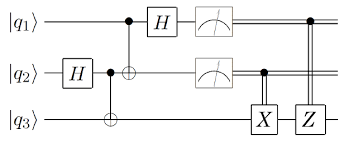

By supposing $|q_1> = |\psi>$ and $|q_2> = |0>$ are Alice's qubits and $|q_3> = |0>$ is Bob's qubit, the protocol follows the five steps below :

1 - Alice and Bob share a $ERP$ state (thanks to a third party). Then $|q_2> = |ERP>$

2 - Alice applies a $CNOT$ gate on $|\psi>$ and her part of $|ERP>$ and an $H$ gate on the first qubit.

3 - Alice measures her qubits in the standard basis.

4 - Alice transmits her two classical bits $b_0$ and $b_1$ to Bob so she can tell him to apply or not apply $X$ and $Z$ gates according to her measurement.
* 00 -> do nothing
* 01 -> Apply $X$ gate
* 10 -> Apply $Z$ gate
* 11 -> Apply $Z$ and $X$ gate

5 - Bob’s qubit is $|\psi>$.

In [4]:
from qiskit import* 
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

%matplotlib inline

IBMQ.load_account()

provider=IBMQ.get_provider('ibm-q')

simulator=Aer.get_backend('qasm_simulator')

ibmqfactory.load_account:WARNING:2021-06-08 11:29:28,765: Credentials are already in use. The existing account in the session will be replaced.


In [5]:
from typing import *
import math

class circuitBuilder(object):
    def __init__(self,minCiruitsize:Tuple[int,int],builder:Callable[[QuantumCircuit,Any],QuantumCircuit],stateValidator:Callable[[Any],bool] = lambda s: True,state = None):
        self._builder = builder
        self._validator = stateValidator
        self.minCiruitsize = minCiruitsize

        if self.isValidState(state):
            self._state = state
        else:
            raise TypeError(f"Invalide state {state}")
        
    def __call__(self,circuit:QuantumCircuit) -> QuantumCircuit:
        return self._builder(circuit,self._state)
    
    def setState(self,state:Any):
        if self.isValidState(state):
            self._state = state
        else :
            raise TypeError(f"Invalide state {state}")
        
    def isValidState(self,state:Any) -> bool:
        return self._validator(state)

class Qubit(object):
    def __init__(self,c1:complex,c2:complex):
        if not math.isclose(abs(c1)**2+abs(c2)**2, 1):
            raise ValueError(f"Invalid Qubit state {c1}|0> + {c2}|1> sum of amplitudes-squared does not equal one. ")
        self.c1 = c1
        self.c2 = c2

    def QubitValidator(s:Any) -> bool:
        return isinstance(s,Qubit)

    def toVector(self)->list:
        return [self.c1,self.c2]
    
    def __str__(self) -> str:
        return f"[{self.c1};{self.c2}]"

def teleportBuilder(circuit:QuantumCircuit,state:Qubit)->QuantumCircuit:

    circuit.initialize(state.toVector(),0)

    circuit.h(1)
    circuit.cnot(1,2)
    
    circuit.barrier()

    circuit.cnot(0,1)
    circuit.h(0)

    circuit.barrier()

    circuit.cnot(1,2)
    circuit.cz(0,2)

    circuit.barrier()

    circuit.measure(2,0)

    return circuit

In [30]:
import time
from qiskit.providers.ibmq import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import clear_output
import pytz

class Reprinter(object):
    def __init__(self) -> None:
        self.out = widgets.Output()
        display(self.out)

    def reprint(self,text):
        with self.out:
            clear_output()
        self.print(text)

    def print(self,text):
        with self.out:
            print(text)
            
def prettyDelta(timed:timedelta) -> str:
    s = int(timed.total_seconds())
    m,s = divmod(s,60)
    h,m = divmod(m,60)
    d,h = divmod(h,24)

    string = ""

    if(d >0):
        string += "{0:02}d ".format(d)

    if (h>0):
        string += "{0:02}h ".format(h)

    if (m>0):
        string += "{0:02}m ".format(m)

    if (s>0):
        string += "{0:02}s ".format(s)
    return string

def autoSelectQComputer(filter:"list[str]",builder:circuitBuilder,states:list,maxQueuedJob:int = 10) -> IBMQBackend:
    provider=IBMQ.get_provider('ibm-q')
    simulator=Aer.get_backend('qasm_simulator')
    
    # avoid side effect
    filter = filter.copy()
    
    # filter q computers with too much pending jobs
    for f in filter:
        qcomputer = provider.get_backend(f)
        if qcomputer.status().pending_jobs > maxQueuedJob:
            filter.remove(f)
            continue
        joblim = qcomputer.job_limit()
        if joblim.maximum_jobs - joblim.active_jobs > len(states):
            print(f"[Warning] number of states is superior to the number of available jobs for the backend {f} autoselection may take longer than expected")
    
    # data holder
    jobs = {s:{n:{"job":None,"expeResult":None,"status":None} for n in filter} for s in states}
    
    # preparing fancy print
    slen = max([len(str(s)) for s in states])

    filterLen = {f:min(len(f),11) for f in filter}

    header = "|" + "state".center(slen," ") + "|"
    delim = "+" + "-" * slen + "+"

    for f in filter:
        header += f.center(max(len(f)+2,11)," ") + "|"
        delim += "-" * max(len(f)+2,11) + "+"
        
    circuit = QuantumCircuit(*builder.minCiruitsize)
    circuit = builder(circuit)
    display(circuit.draw("mpl"))
    
    printer = Reprinter()
    
    printer.print(header)
    printer.print(delim)
    
    
    
    # creating jobs
    for s in states:

        line = "|" + str(s).center(slen," ") + "|"

        builder.setState(s)
        circuit = QuantumCircuit(*builder.minCiruitsize)
        circuit = builder(circuit)
        counts = execute(circuit,backend = simulator,shots=512).result().get_counts()
        jobs[s]["simResult"] = {k:counts[k] for k in counts}

        for f in filter:
            line += "QUEUED".center(max(len(f)+2,11)," ") + "|"
            qcomputer = provider.get_backend(f)
            while (True):
                joblim = qcomputer.job_limit()
                if joblim.maximum_jobs - joblim.active_jobs >=1:
                    break
                time.sleep(2)
            jobs[s][f]["job"] = execute(circuit,backend = qcomputer,shots=512)
            
        printer.print(line)
    printer.print(delim)
        
    jobsLeft = len(states)*len(filter)
    printer.print(f"Jobs Left : {jobsLeft}")
    
    # waiting for all jobs to end and gathering data
    while jobsLeft >0:
        time.sleep(10)
        Gstatus = header + "\n" + delim + "\n"
        eta = datetime.now(pytz.UTC)
        for s in states:
            Gstatus += "|" + str(s).center(slen," ") + "|"
            for f in filter:
                status = jobs[s][f]["job"].status()
                if status.name == "QUEUED" :
                    queueInfo = jobs[s][f]['job'].queue_info()
                    if queueInfo != None and queueInfo.estimated_complete_time > eta:
                        eta = queueInfo.estimated_complete_time
                    Gstatus += f"{status.name}({jobs[s][f]['job'].queue_position()})".center(max(len(f)+2,11)," ") + "|"

                else :
                    Gstatus += status.name.center(max(len(f)+2,11)," ") + "|"

                if jobs[s][f]["status"] != None :
                    continue
                
                if (status.name in ['DONE', 'CANCELLED', 'ERROR']):
                    jobsLeft -= 1
                    
                    if status.name == 'DONE':
                        counts = jobs[s][f]["job"].result().get_counts()
                        
                        jobs[s][f]["expeResult"] = {k:counts[k] for k in counts}

                    jobs[s][f]["status"] = status.name
            Gstatus += "\n"
        Gstatus += delim + f"\nJobs Left : {jobsLeft} ETA : " + prettyDelta(eta - datetime.now(pytz.UTC))
        printer.reprint(Gstatus)

    errors = {f:{"count":0,"tot":0} for f in filter}
    
    # processing error
    for s in states:
        for f in filter:
            if jobs[s][f]["status"] == 'DONE':
                errors[f]["tot"] += 512
                for k in jobs[s]["simResult"].keys():
                    errors[f]["count"] += abs(jobs[s][f]["expeResult"][k] - jobs[s]["simResult"][k])
    
    back = None
    error = 2.0
    
    #finding the best q computer
    for (k,v) in errors.items() :
        if (v["tot"]>0):
            e = float(v["count"])/v["tot"]
            if e<error:
                error = e
                back = k
    
    print(error)
    print(back)
    return provider.get_backend(back)

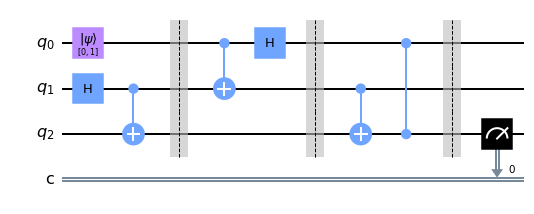

Output()

0.03515625
ibmq_santiago


In [31]:
proco = ["ibmq_manila","ibmq_santiago","ibmq_athens","ibmq_belem","ibmq_quito","ibmqx2"]#,"ibmq_lima"

qcomputer = autoSelectQComputer(proco, circuitBuilder((3,1),teleportBuilder,Qubit.QubitValidator,Qubit(0,1)), [Qubit(1,0),Qubit(0,1)] )


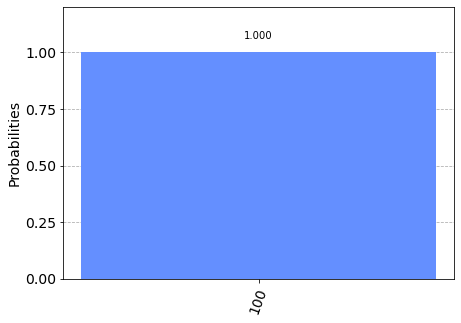

In [39]:
result=execute(tcircuit,backend = simulator,shots=1024).result()
counts=result.get_counts()

plot_histogram(counts)

In [17]:
class Binary(object):
    def __init__(self,binary):
        self.binary = str(binary)
        if not Binary.isBinary(self.binary):
            raise TypeError(self.binary + "is not a binary number")
        
    def isBinary(binary:str):
        for i in range(len(binary)):
            if binary[i] != "1" and binary[i] != "0":
                return False
        return True
    
    def __getitem__(self, name: int) -> int:
        return int(self.binary[len(self.binary) - name-1])
    
    def __len__(self) -> int:
        return len(self.binary)
    
    def __str__(self) -> str:
        return self.binary

In [32]:
def toBCounts(counts):
    return {Binary(k):counts[k] for k in counts}

def getError(ccounts,expected):
    E=0.0
    T=0
    for k,v in ccounts.items():
        T += v
        if k[2] !=  expected :
            E += v
    return E/T

print(getError(BCounts,0))
       

0.0


In [42]:
jobs = []

vals = []

for p in proco:
    jobs.append((p,execute(tcircuit,backend = provider.get_backend(p),shots=512)))

In [44]:
for j in jobs :
    print(j[0])
    job_monitor(j[1])
    vals.append((j[0],getError(toBCounts(j[1].result().get_counts()),1)))

vals.sort(key=lambda c:c[1])

ibmq_manila
Job Status: job has successfully run
ibmq_santiago
Job Status: job has successfully run
ibmq_athens
Job Status: job has successfully run
ibmq_belem
Job Status: job has successfully run
ibmq_quito
Job Status: job has successfully run
ibmq_lima
Job Status: job is queued (33)

KeyboardInterrupt: 

In [45]:
vals.sort(key=lambda c:c[1])
print(vals)

[('ibmq_belem', 0.861328125), ('ibmq_quito', 0.873046875), ('ibmq_manila', 0.90234375), ('ibmq_athens', 0.9296875), ('ibmq_santiago', 0.94140625)]


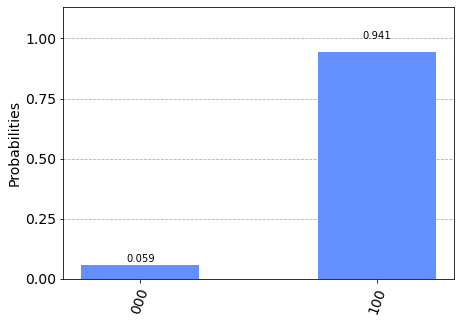

In [48]:
p=None
for j in jobs :
    if (j[0] == 'ibmq_santiago'):
        p=plot_histogram(j[1].result().get_counts())
p

## Quantum Teleportation's Validity

Let be $|\psi> = \alpha|0> + \beta|1>$ the Alice's qubit she wants to send to Bob.

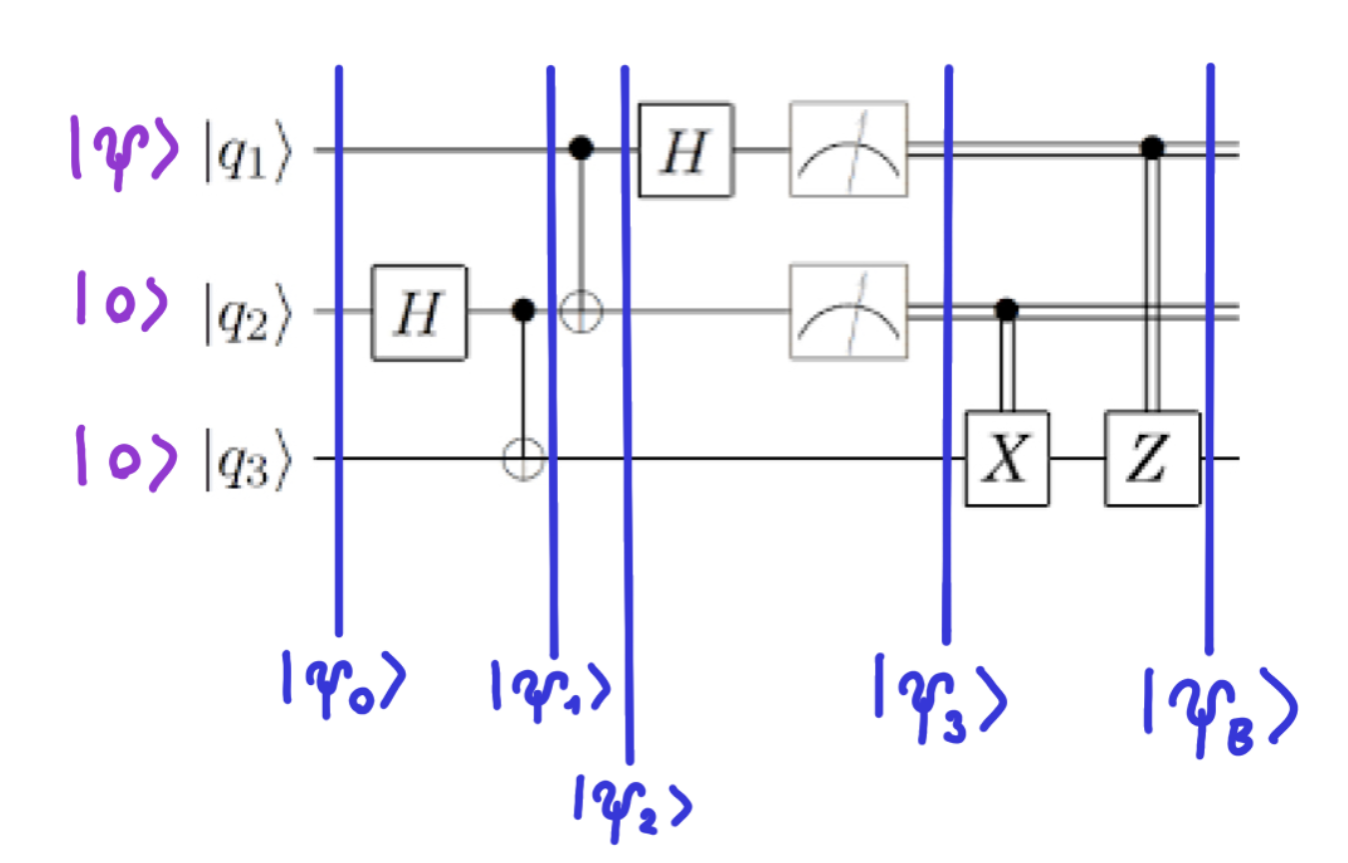

To prove the validity of the protocol, we need to check at each step the state of $|\psi_i>$ and then that $|\psi_B> = |\psi>$ at the end of the protocol.

- $|\psi_0> = |\psi> \otimes |0> \otimes |0> = (\alpha|0> + \beta|1>) \otimes |0> \otimes |0>$
- $|\psi_1> = |\psi> \otimes |EPR> = (\alpha|0> + \beta|1>) \otimes \frac{1}{\sqrt{2}}(|00> + |11>) = \frac{1}{\sqrt{2}}(\alpha|000> + \alpha|011> + \beta|100> + \beta|111>)$
- $|\psi_2> = CNOT(|\psi_1>) = CNOT(\frac{1}{\sqrt{2}}(\alpha|000> + \alpha|011> + \beta|100> + \beta|111>)) = \frac{1}{\sqrt{2}}(\alpha|000> + \alpha|011> + \beta|110> + \beta|101>)$
- $|\psi_3> = (H \otimes I \otimes I)|\psi_2> = \frac{1}{\sqrt{2}}(\alpha|+>|00> + \alpha|+>|11> + \beta|->|10> + \beta|->|01>)$

Let's put it in the standard basis,
$$|\psi_3> = \frac{1}{\sqrt{2}}(\alpha(\frac{|0>+|1>}{\sqrt{2}})\otimes|00> + \alpha(\frac{|0>+|1>}{\sqrt{2}})\otimes|11> + \beta(\frac{|0>-|1>}{\sqrt{2}})\otimes|10> + \beta(\frac{|0>-|1>}{\sqrt{2}})\otimes|01>)$$
$$|\psi_3> = \frac{1}{\sqrt{2}}(\alpha|000> + \alpha|100> + \alpha|011> + \alpha|111> + \beta|010> + \beta|110> + \beta|101> + \beta|001>)$$

As this step, we need Alice's measurement to get the expected result. So, we must check on a case-by-case basis.

- Suppose Alice measures $|00>$:
$$|\psi_3> = \frac{1}{2} \frac{\alpha|000> + \beta|001>}{\frac{1}{2}(\sqrt{1+1})^2} = \alpha|000> + \beta|001> = |00> \otimes \underbrace{\alpha|0> + \beta|1>}_{|\psi>} = |\psi_B>$$

- Suppose Alice measures $|01>$:
$$|\psi_3> = \frac{1}{2} \frac{\alpha|011> + \beta|010>}{\frac{1}{2}(\sqrt{1+1})^2} = \alpha|011> + \beta|010> = |01> \otimes \underbrace{\alpha|1> + \beta|0>}_{\neq |\psi>}$$
Then Bob applies a $X$ gate to find $|\psi>$, $|\psi_B> = X \otimes |\psi_3> = |01> \otimes \underbrace{\alpha|0> + \beta|1>}_{|\psi>}$

- Suppose Alice measures $|10>$:
$$|\psi_3> = \frac{1}{2} \frac{\alpha|100> + \beta|101>}{\frac{1}{2}(\sqrt{1+1})^2} = \alpha|100> + \beta|101> = |10> \otimes \underbrace{\alpha|1> - \beta|0>}_{\neq |\psi>}$$
Then Bob applies a $Z$ gate to find $|\psi>$, $|\psi_B> = Z \otimes |\psi_3> = |10> \otimes \underbrace{\alpha|0> + \beta|1>}_{|\psi>}$

- Suppose Alice measures $|11>$:
$$|\psi_3> = \frac{1}{2} \frac{\alpha|111> + \beta|110>}{\frac{1}{2}(\sqrt{1+1})^2} = \alpha|111> + \beta|110> = |11> \otimes \underbrace{\alpha|1> - \beta|0>}_{\neq |\psi>}$$
Then Bob applies a $X$ gate and a $Z$ gate to find $|\psi_B> = |\psi>$, $Z \otimes (H \otimes |\psi_3>) = |11> \otimes \underbrace{\alpha|0> + \beta|1>}_{|\psi>}$

Conclusion : At the end of the protocol, $|\psi_B> = |\psi>$.